In [1]:
from sklearn.metrics import mean_squared_error, r2_score
from sksurv.metrics import concordance_index_censored as ci_scikit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# to change path when new data is extracted
jobid="job_2021071010171653411016_homo_secureboost"
party_A="_0_guest_1234_output_data"
party_B="_0_host_2222_output_data"
party_C="_0_host_3333_output_data"
full_path="C:/Users/chanzl_thinkpad/Dropbox/Imperial/Individual Project/NASA/survival-analysis-nasa/"
central_test_results="C:/Users/chanzl_thinkpad/Dropbox/Imperial/Individual Project/NASA/survival-analysis-nasa/graphing.csv"
filename = "data.csv"

In [2]:
df_A=pd.read_csv(os.path.join(jobid+party_A, filename))
df_B=pd.read_csv(os.path.join(jobid+party_B, filename))
df_C=pd.read_csv(os.path.join(jobid+party_C, filename))
graph_data=pd.read_csv(central_test_results)
test_clipped = pd.read_csv(full_path + 'Dataset/processed/test_clipped.csv')
test_trend = pd.read_csv(full_path + 'Dataset/processed/rul_rf_test_trended.csv')
list_results = pd.read_excel(full_path + 'results/saved_results_22-06-2021_204708.xlsx')

In [3]:
df_A.head()

,id,label,predict_result,predict_score,predict_detail,type
0,101,150.0,149.963149,149.963149,{'label': 149.96314944295597},train
1,102,150.0,149.955036,149.955036,{'label': 149.95503639943595},train
2,103,132.0,131.987529,131.987529,{'label': 131.98752869665597},train
3,104,112.0,112.262538,112.262538,{'label': 112.26253792999597},train
4,105,92.0,92.169167,92.169167,{'label': 92.16916684156597},train


# Helper functions

In [4]:
def format_FL_output(df):
    df['cycle'] = 0
    df['unit num'] = 0
    df.loc[df['type'] == "train", "cycle"] = df.id % 100
    df.loc[df['type'] == "validate", "cycle"] = df.id % 100000
    
    # retrieve unit num
    df.loc[df['type'] == "train", "unit num"] = (df['id'] - df['cycle']) / 100
    df.loc[df['type'] == "validate", "unit num"] = (df['id'] - df['cycle']) / 100000
    
    df['unit num'] = df['unit num'].astype(int)
    df.rename(columns={'predict_result': 'y_hat'}, inplace=True)

# Formatting federated output

In [5]:
format_FL_output(df_A)
format_FL_output(df_B)
format_FL_output(df_C)

In [6]:
df_master_FL = df_A.copy()
df_master_FL=df_master_FL.append(df_B)
df_master_FL=df_master_FL.append(df_C)

In [7]:
# drop rows that are train
df_train_FL = df_master_FL[df_master_FL.type == "train"]
df_test_FL = df_master_FL[df_master_FL.type == "validate"]

# sort
df_train_FL.sort_values(['unit num', 'cycle'], ascending=[True, True], inplace=True)
df_test_FL.sort_values(['unit num', 'cycle'], ascending=[True, True], inplace=True)

# reset index
df_train_FL.reset_index(inplace=True)
df_test_FL.reset_index(inplace=True)

C:\Users\chanzl_thinkpad\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\chanzl_thinkpad\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [8]:
#df_test_FL.to_excel("TEST.xlsx")

# Adding back prediction back for graphing.csv

In [9]:
test_clipped.head(10)

,unit num,cycle,sens2,sens3,sens4,sens7,sens8,sens11,sens12,sens13,sens15,sens17,sens20,sens21,RUL,breakdown,start
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,47.20,521.72,2388.03,8.4052,392,38.86,23.3735,142,0,0
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,47.50,522.16,2388.06,8.3803,393,39.02,23.3916,141,0,1
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,47.50,521.97,2388.03,8.4441,393,39.08,23.4166,140,0,2
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,47.28,521.38,2388.05,8.3917,391,39.00,23.3737,139,0,3
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,47.31,522.15,2388.03,8.4031,390,38.99,23.4130,138,0,4
5,1,6,642.11,1579.12,1395.13,554.22,2388.00,47.26,521.92,2388.08,8.4238,392,38.91,23.3467,137,0,5
6,1,7,642.11,1583.34,1404.84,553.89,2388.05,47.31,522.01,2388.06,8.3914,391,38.85,23.3952,136,0,6
7,1,8,642.54,1580.89,1400.89,553.59,2388.05,47.21,522.09,2388.06,8.4213,393,39.05,23.3224,135,0,7
8,1,9,641.88,1593.29,1412.28,554.49,2388.06,47.37,522.03,2388.05,8.4353,391,39.10,23.4521,134,0,8
9,1,10,642.07,1585.25,1398.64,554.28,2388.04,47.14,522.00,2388.06,8.4093,391,38.87,23.3820,133,0,9


In [10]:
def map_test_result(df_temp, df_main, L=20):
    interim_result = df_main.copy()
    interim_result['y_hat'] = 0
    count = 0
    for engine in interim_result['unit num'].unique():
        # get first and last index position of each set of engine
        first_idx = interim_result['unit num'].eq(engine).idxmax()
        last_idx = interim_result['unit num'].eq(engine+1).idxmax()-1
        if last_idx == -1:
            last_idx = len(interim_result)-1

        # populate RUL for middle cycles
        while (last_idx - first_idx) >= L-1:
            mid_idx = first_idx + L - 1
            interim_result.iat[mid_idx, -1] = df_temp.iloc[count]['y_hat']
            anchor_up = df_temp.iloc[count]['y_hat']
            anchor_down = df_temp.iloc[count]['y_hat']
            count += 1
            first_idx += L
            for offset in range(1, L):
                interim_result.iat[mid_idx-offset, -1] = anchor_up + 1
                anchor_up += 1

        # populate RUL for remaining cycles
        for offset in range(1, last_idx-mid_idx+1):
            interim_result.iat[mid_idx + offset, -1] = anchor_down - 1
            anchor_down -= 1

    return interim_result

In [11]:
df_temp = test_trend.copy()
df_temp['y_hat']=df_test_FL['y_hat']
df_temp.to_excel("df_temp.xlsx")
df_result = map_test_result(df_temp, test_clipped)
graph_data['FL-GBDT (Trended)'] = df_result['y_hat']

# Plotting output

In [12]:
def make_graph(selected_unit_num):
    fig, axs = plt.subplots(int(len(selected_unit_num)/2), 2)
    models = ['RUL', 'NN (tuned)', 'RF (trended)', 'FL-GBDT (Trended)']
    i = -1
    for ax in axs.flatten():
        i += 1
        df_graph = graph_data[graph_data['unit num'] == selected_unit_num[i]]
        ax.set_title('Test engine ' + str(selected_unit_num[i]))
        for col in models:
            if col == 'RUL':
                ax.plot(df_graph['cycle'], df_graph[col], label=col, linestyle='dashed', linewidth=0.75)
            else:
                ax.plot(df_graph['cycle'], df_graph[col], label=col, linewidth=0.75)
    fig.legend(models, loc='lower center',
               ncol=len(models), bbox_transform=fig.transFigure)
    plt.xlabel('Cycles')
    plt.ylabel('RUL')
    # plt.rcParams["figure.figsize"] = (200,30)  # width x height
    # plt.figure(figsize=(50,10))
    plt.show()

In [13]:
def evaluate(model, df_result, label='test'):
    """ Evaluates model output on rmse, R2 and C-Index
    Args:
    model (string): name of model for documentation
    df_result (pandas.df): dataframe with the headers 'unit num', 'RUL', 'y_hat', 'breakdown'
    label (string): type of output (train or test)

    Returns:
    list: returns [model, label, rmse, ci_sk, variance]
    """

    y_true = df_result['RUL']
    y_hat = df_result['y_hat']
    df_result['breakdown'].replace(0, False, inplace=True)  # rsf only takes true or false
    df_result['breakdown'].replace(1, True, inplace=True)  # rsf only takes true or false

    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)

    # the concordance index (CI) is interested on the order of the predictions, not the predictions themselves
    # CI can only be measured between individual samples where a censoring or failure event occurred
    # https://medium.com/analytics-vidhya/concordance-index-72298c11eac7#:~:text=The%20concordance%20index%20or%20c,this%20definition%20mean%20in%20practice
    df_result_grouped = df_result.groupby('unit num').last()
    breakdown = df_result_grouped['breakdown']
    y_true = df_result_grouped['RUL']
    y_hat = df_result_grouped['y_hat']
    ci_sk = ci_scikit(breakdown, y_true, y_hat)[0]
    score = nasaScore(y_true, y_hat)  # score should be based on the last instance
    # print(f'Number of concordant pairs (scikit-survival): {ci_scikit(breakdown, y_true, y_hat)[1]}')
    # print(f'Number of discordant pairs (scikit-survival): {ci_scikit(breakdown, y_true, y_hat)[2]}')
    # print(f'Number of pairs having tied estimated risks (scikit-survival): {ci_scikit(breakdown, y_true, y_hat)[3]}')
    # print(f'Number of comparable pairs sharing the same time (scikit-survival): {ci_scikit(breakdown, y_true, y_hat)[4]}')
    print('{} set RMSE:{:.2f}, Score:{:.2f}, CI(scikit):{:.4f}, R2:{:.2f}'.format(label, rmse, score, ci_sk, variance))
    result = [model, label, rmse, score, ci_sk, variance]
    return result

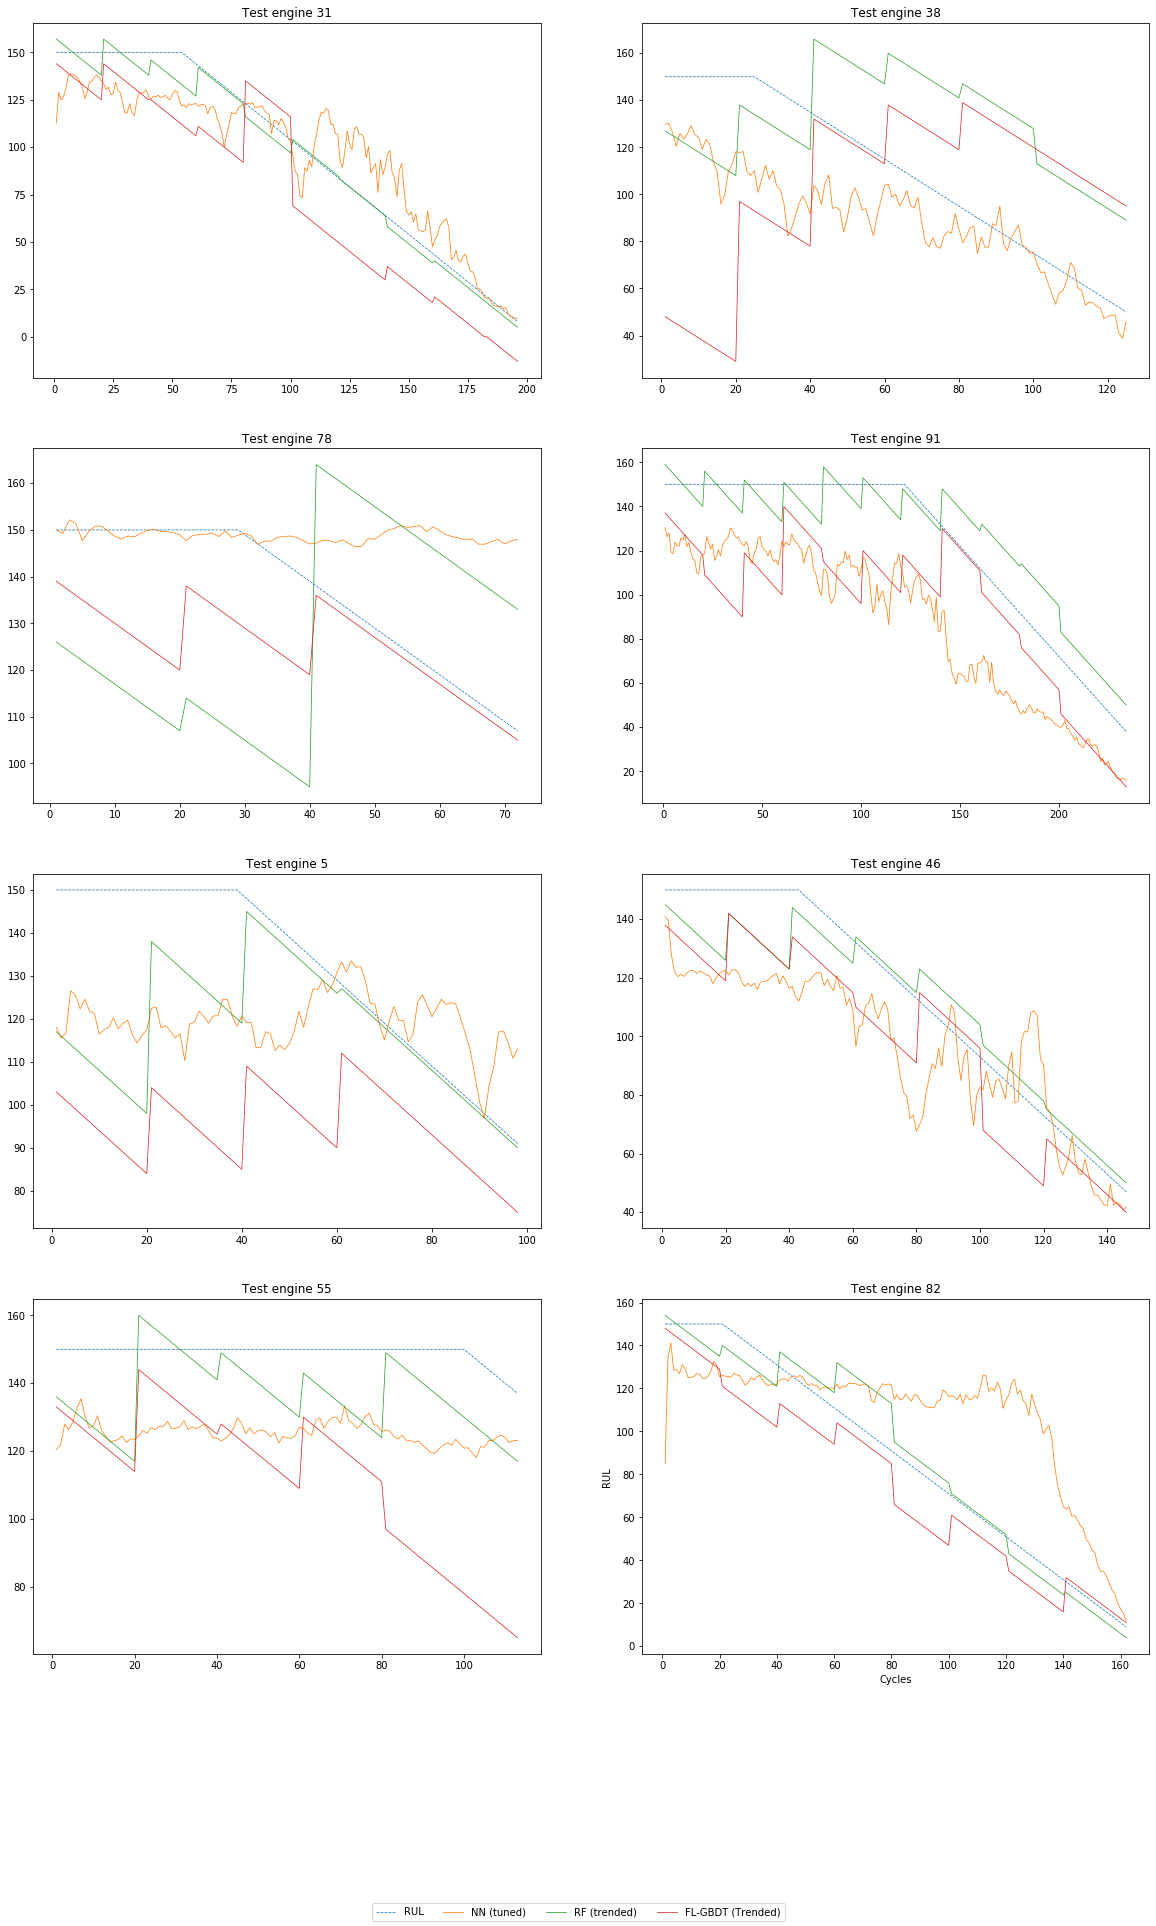

In [14]:
plt.rcParams["figure.figsize"] = (20,30)
make_graph([31, 38, 78, 91, 5, 46, 55, 82])

# Calculating RMSE and add to total result

In [15]:
def nasaScore(RUL_true, RUL_hat):
    d = RUL_hat - RUL_true
    score = 0
    for i in d:
        if i >= 0:
            score += np.math.exp(i / 13) - 1
        else:
            score += np.math.exp(- i / 10) - 1
    return score/len(RUL_true)  # should the score be averaged?

In [16]:
list_results.drop('timestamp', axis=1, inplace=True)

In [17]:
result = evaluate("FL-GBDT (Trended)", df_result, 'test')
temp = pd.DataFrame([result])
temp.columns=['model_name', "train_test", 'RMSE', 'Score', 'CI_SK', 'R2']
temp.head()

test set RMSE:37.13, Score:824.25, CI(scikit):0.2066, R2:-0.05


,model_name,train_test,RMSE,Score,CI_SK,R2
0,FL-GBDT (Trended),test,37.131537,824.251301,0.206577,-0.04701


In [18]:
list_results=list_results.append(temp, ignore_index=True)
list_results.sort_values(['train_test', 'RMSE'], ascending=[True, True], inplace=True)
list_results.reset_index(inplace=True, drop=True)
list_results.head(25)

,model_name,train_test,RMSE,Score,CI_SK,R2
0,RF (trended),test,16.626900,8.440800,0.168000,0.79010
1,NN (tuned),test,24.765800,10.246900,0.164700,0.53420
2,RF (pre-tuned),test,27.576600,8.480900,0.174200,0.42250
3,RF (tuned),test,27.804400,9.701800,0.188100,0.41290
4,Cox,test,31.807600,15.398300,0.186700,0.23170
5,rsf (pre-tuned),test,33.832200,13744.516700,0.290100,0.13080
6,rsf (tuned),test,34.131700,15500.418100,0.299200,0.11530
7,KM_rmst,test,34.296300,4058.178300,0.283400,0.10680
8,FL-GBDT (Trended),test,37.131537,824.251301,0.206577,-0.04701
9,NN (pre-tuned),test,38.224300,132.847100,0.193200,-0.10950
